#** Using Vgg16 architecture**

In [1]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/HACKER EARTH/images.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')


finish


##Importing necessary Files

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import cv2
from PIL import Image

from keras import layers
from tensorflow.keras import applications 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm




# import the libraries as shown below
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
from keras.preprocessing import image
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.utils import np_utils


###Reading the file

In [6]:
train = pd.read_csv("/content/dataset/train.csv")
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [7]:
train.shape

(6469, 2)

In [8]:
#train['Class'].value_counts()
train.groupby(by = "Class").count()

,Image
Class,
Airplane,535
Candle,593
Christmas_Tree,1539
Jacket,640
Miscellaneous,2801
Snowman,361


In [9]:
# useful for getting number ofimages
folders = glob('/content/dataset/train/*')

In [10]:
len(folders)

6469

###Set Path into a variable

In [11]:
## set path for images
TRAIN_PATH = '/content/dataset/train/'
TEST_PATH = '/content/dataset/test/'

In [12]:
IMG_SIZE = 224

def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [13]:
train_img = []
for img_name in tqdm(train['Image'].values):
    train_img.append(read_img(TRAIN_PATH + img_name ))
  ##Scaling the image  
x_train = np.array(train_img, np.float32) / 255
print(x_train.shape)

100%|██████████| 6469/6469 [00:02<00:00, 3047.15it/s]


(6469, 224, 224, 3)


In [14]:
class_list = train['Class'].tolist()
class_numeric = {k: v+1 for v, k in enumerate(set(class_list))}
y_train = [class_numeric[k] for k in class_list]
y_train = np.array(y_train)

In [15]:
y_train = to_categorical(y_train)
print(y_train.shape)

(6469, 7)


###Initialize Vgg16 model 

In [16]:
vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
add_model = Sequential()#sequential layer
add_model.add(Flatten(input_shape=vgg16.output_shape[1:]))#flattening
add_model.add(Dropout(0.3))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=vgg16.input, outputs=add_model(vgg16.output))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

###Data Augmentation

In [19]:
batch_size = 32      
epochs = 50

In [20]:
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

###Fitting the model and train on tran images set

In [21]:
history = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
202/202 [==============================] - 103s 471ms/step - loss: 1.6751 - accuracy: 0.3979
Epoch 2/50
202/202 [==============================] - 92s 456ms/step - loss: 1.1449 - accuracy: 0.5795
Epoch 3/50
202/202 [==============================] - 93s 460ms/step - loss: 0.8667 - accuracy: 0.6828
Epoch 4/50
202/202 [==============================] - 93s 461ms/step - loss: 0.7201 - accuracy: 0.7299
Epoch 5/50
202/202 [==============================] - 94s 462ms/step - loss: 0.6465 - accuracy: 0.7610
Epoch 6/50
202/202 [==============================] - 94s 463ms/step - loss: 0.5783 - accuracy: 0.7886
Epoch 7/50
202/202 [==============================] - 94s 463ms/step - loss: 0.5135 - accuracy: 0.8111
Epoch 8/50
202/202 [==============================] - 94s 463ms/step - loss: 0.4851 - accuracy: 0.8234
Epoch 9/50
202/202 [==============================] - 94s 463ms/step - loss: 0.4676 - accuracy: 0.8305
Epoch 10/50
202/202 [==============================] - 94s 466ms/step - 

###Collecting the garbage

In [22]:
import gc
gc.collect()

122

In [23]:
import os

##Evaluate the test images folders for testing the prediction on the basis of Trainable model

In [24]:
test_images = os.listdir(TEST_PATH)
test_img = []
for image in test_images:
    test_img.append(read_img(TEST_PATH + image))

In [25]:

##Scaling the images
x_test = np.array(test_img, np.float32) / 255
predictions = model.predict(x_test)

In [26]:
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in class_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

##Final submission of Our Result

In [27]:
data = pd.DataFrame({'Image': test_images, 'Class': pred_labels})
data.to_csv('submission_vgg16.csv', index = False)
data.head(20),data.shape

(            Image           Class
 0    image715.jpg   Miscellaneous
 1   image2029.jpg         Snowman
 2   image6577.jpg   Miscellaneous
 3   image9721.jpg          Jacket
 4   image3077.jpg   Miscellaneous
 5   image4535.jpg   Miscellaneous
 6   image7472.jpg   Miscellaneous
 7   image3584.jpg  Christmas_Tree
 8   image5404.jpg   Miscellaneous
 9   image2992.jpg   Miscellaneous
 10  image5770.jpg          Candle
 11  image8557.jpg  Christmas_Tree
 12  image5871.jpg          Jacket
 13  image8986.jpg         Snowman
 14   image685.jpg   Miscellaneous
 15  image1943.jpg   Miscellaneous
 16  image3526.jpg         Snowman
 17  image5796.jpg  Christmas_Tree
 18  image9653.jpg  Christmas_Tree
 19  image1160.jpg   Miscellaneous, (3489, 2))

##This Showws Our Predicted Results is right i.e is belongs to  Miscellaneous Class

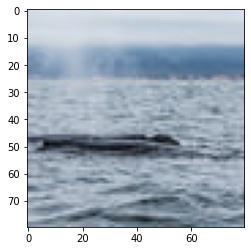

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("/content/dataset/test/image1943.jpg")
plt.imshow(image)
plt.show()

In [29]:
data=pd.read_csv('submission_vgg16.csv')

In [30]:
data.head()

,Image,Class
0,image715.jpg,Miscellaneous
1,image2029.jpg,Snowman
2,image6577.jpg,Miscellaneous
3,image9721.jpg,Jacket
4,image3077.jpg,Miscellaneous


In [31]:
data['Class'].value_counts()

Miscellaneous     1612
Christmas_Tree     807
Jacket             344
Candle             288
Airplane           258
Snowman            180
Name: Class, dtype: int64

#Thank You!!